## Data and Package Importing

In [1]:
import sys
sys.path.append('../')
from QC import *
sc.settings.set_figure_params(dpi=80, frameon=False)

### Load data and preprocess

In [2]:
%time s1 = sc.read_h5ad('../data/3777-SM-2-CTTGTA_S2.h5ad')

CPU times: user 2.38 s, sys: 375 ms, total: 2.76 s
Wall time: 2.76 s


In [3]:
s1

AnnData object with n_obs × n_vars = 5754 × 38459 
    obs: 'ken_filter'

In [4]:
# checkpoint raw data for future filtering
s1.raw = s1

In [5]:
s1.var_names[s1.var_names.str.contains('mt-')] # check gene label format

Index(['mt-Atp6', 'mt-Atp8', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1',
       'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6', 'mt-Rnr1',
       'mt-Rnr2', 'mt-Ta', 'mt-Tc', 'mt-Td', 'mt-Te', 'mt-Tf', 'mt-Tg',
       'mt-Th', 'mt-Ti', 'mt-Tk', 'mt-Tl1', 'mt-Tl2', 'mt-Tm', 'mt-Tn',
       'mt-Tp', 'mt-Tq', 'mt-Tr', 'mt-Ts1', 'mt-Ts2', 'mt-Tt', 'mt-Tv',
       'mt-Tw', 'mt-Ty'],
      dtype='object', name='index')

In [6]:
%%time
# quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality
reorder_adata(s1)

# create new "observations" as percent and mean mito genes
s1.var['mito'] = s1.var_names.str.contains('mt-') # identify mitochondrial genes
s1.obs['mean_mito'] = np.mean(s1[:,s1.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(s1, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var

# rank cells by total counts and save as .obs
s1.obs['ranked_total_counts'] = np.argsort(s1.obs['total_counts'])

CPU times: user 2.18 s, sys: 572 ms, total: 2.75 s
Wall time: 2.75 s


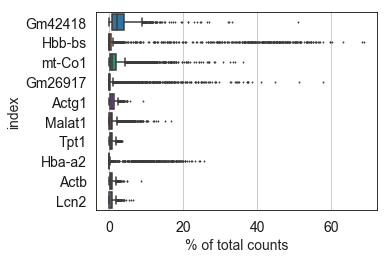

In [7]:
# look at highest expression by gene across all cells
sc.pl.highest_expr_genes(s1, n_top=10)

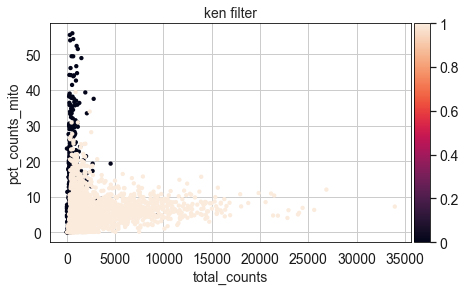

In [8]:
# look at low-quality and dead cell distribution with Ken's filtering
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='ken_filter', size=75)

### Find inflection point

Inflection point at index
3839    1292
4016    1954
3439    2779
2549    3706
745     4699
718     5217
0       5753
Name: total_counts, dtype: int64 for [0, 20, 40, 60, 80, 90, 100] percentiles of greatest secant distances


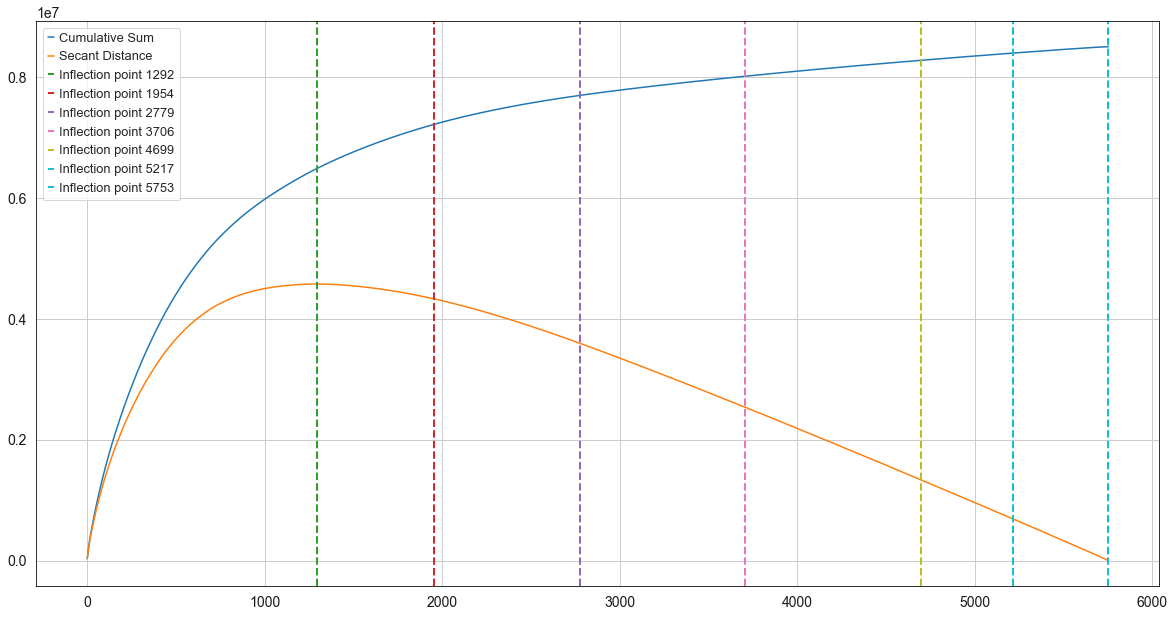

In [9]:
find_inflection(s1, inflection_percentiles = [0,20,40,60,80,90,100])

In [10]:
s1.obs['total_counts'][5217] # see the total counts for the cutoff point

220.0

In [11]:
# create new "observation" as empty droplet label
s1.obs['bagging_empty'] = np.where(s1.obs['total_counts']<=s1.obs['total_counts'][5217], 1, 0) # 1 is "empty", 0 is __initially__ "not empty"

In [12]:
s1.obs['bagging_empty'].value_counts()

0    5204
1     550
Name: bagging_empty, dtype: int64

In [13]:
# create new "observation" as empty droplet label
s1.obs['twostep_empty'] = np.where(s1.obs['total_counts']<=s1.obs['total_counts'][5217], 1, -1) # 1 is empty, -1 is unlabeled
s1.obs.loc[s1.obs['ranked_total_counts']>=s1.n_obs*0.98, 'twostep_empty'] = 0 # take top 3% of dataset by total UMI counts and add as "not empty"

In [14]:
s1.obs['twostep_empty'].value_counts()

-1    5089
 1     550
 0     115
Name: twostep_empty, dtype: int64

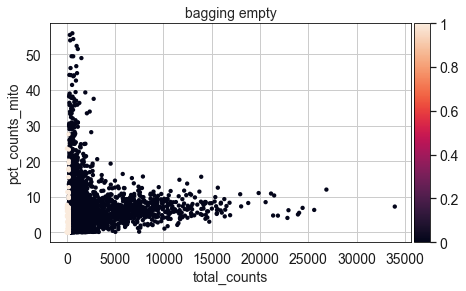

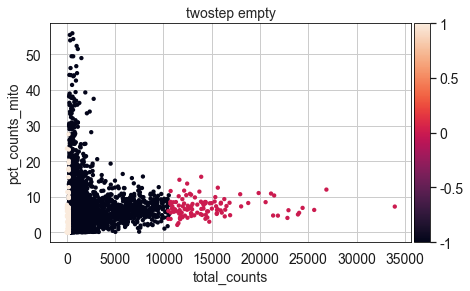

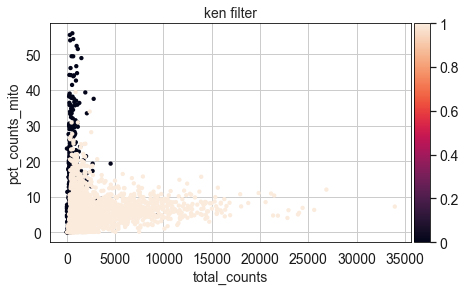

In [18]:
# look at the training labels we've picked
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='bagging_empty', size=75)
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='twostep_empty', size=75)
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='ken_filter', size=75)

### Normalize and perform linear dimensionality reduction with PCA

In [19]:
%%time
sc.pp.normalize_total(s1, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1) # log1p transformation
sc.pp.scale(s1, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 1.34 s, sys: 181 ms, total: 1.52 s
Wall time: 1.52 s


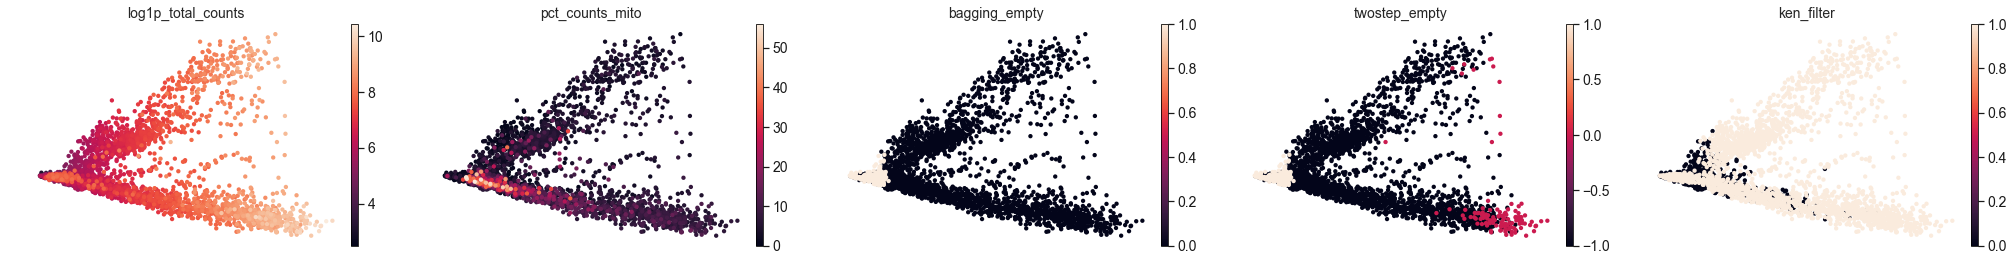

CPU times: user 38.1 s, sys: 2.66 s, total: 40.7 s
Wall time: 7.01 s


In [21]:
%%time
sc.tl.pca(s1, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1, color=['log1p_total_counts','pct_counts_mito','bagging_empty','twostep_empty','ken_filter'], ncols=5, size=75)

---
### PU Bagging

In [22]:
# define X and y for classifier training for simplicity
X = s1.obsm['X_pca'] # training data is PCA results
y = s1.obs['bagging_empty'].copy(deep=True) # training labels are from .obs df

In [23]:
%%time

bc = BaggingClassifierPU(
    DecisionTreeClassifier(), 
    n_estimators = 1000,  # 1000 trees as usual
    max_samples = sum(y), # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc.fit(X, y)

results_bagging_empty = bc.oob_decision_function_[:,1]

CPU times: user 3.95 s, sys: 384 ms, total: 4.34 s
Wall time: 14.7 s


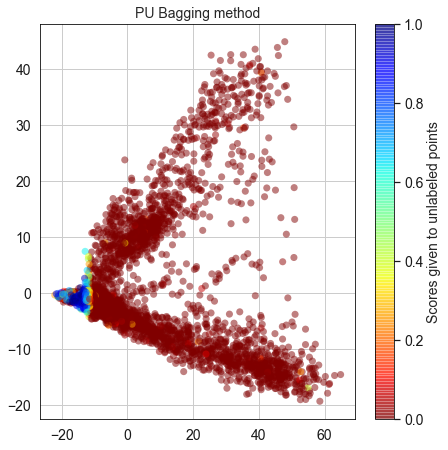

In [24]:
# visualize PU bagging results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    X[:,0], X[:,1], 
    c = results_bagging_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU Bagging method')
plt.show()

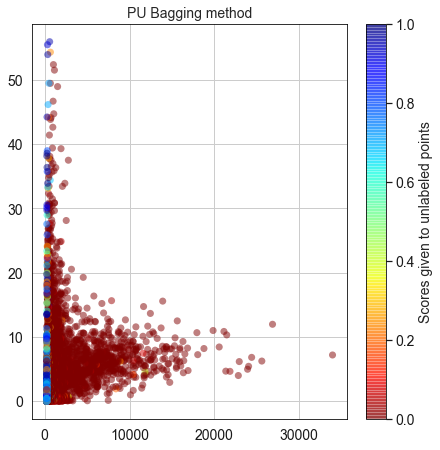

In [25]:
# visualize final PU bagging results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    s1.obs['total_counts'], s1.obs['pct_counts_mito'], 
    c = results_bagging_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU Bagging method')
plt.show()

---
### TwoStep

In [26]:
# define X and y for classifier training for simplicity
X = s1.obsm['X_pca'] # training data is PCA results
y = s1.obs['twostep_empty'].copy(deep=True) # training labels are from .obs df

In [27]:
%%time
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1) # define random forest classifier, you can plug in any classifier though!
scores_twostep_empty, labels_twostep_empty = twoStep(clf=rf, X=X, y=y, n_iter=18)

Step 1 labeled 969 new positives and 54 new negatives.
Iteration 1: Doing step 2... Step 1 labeled 222 new positives and 48 new negatives.
Iteration 2: Doing step 2... Step 1 labeled 72 new positives and 37 new negatives.
Iteration 3: Doing step 2... Step 1 labeled 49 new positives and 14 new negatives.
Iteration 4: Doing step 2... Step 1 labeled 69 new positives and 4 new negatives.
Iteration 5: Doing step 2... Step 1 labeled 37 new positives and 2 new negatives.
Iteration 6: Doing step 2... Step 1 labeled 17 new positives and 3 new negatives.
Iteration 7: Doing step 2... Step 1 labeled 21 new positives and 4 new negatives.
Iteration 8: Doing step 2... Step 1 labeled 15 new positives and 3 new negatives.
Iteration 9: Doing step 2... Step 1 labeled 15 new positives and 0 new negatives.
Iteration 10: Doing step 2... Step 1 labeled 5 new positives and 1 new negatives.
Iteration 11: Doing step 2... Step 1 labeled 15 new positives and 0 new negatives.
Iteration 12: Doing step 2... Step 1 l

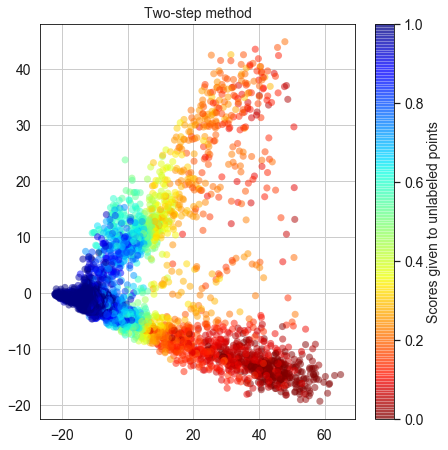

In [28]:
# visualize final TwoStep results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    X[:,0], X[:,1], 
    c = scores_twostep_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

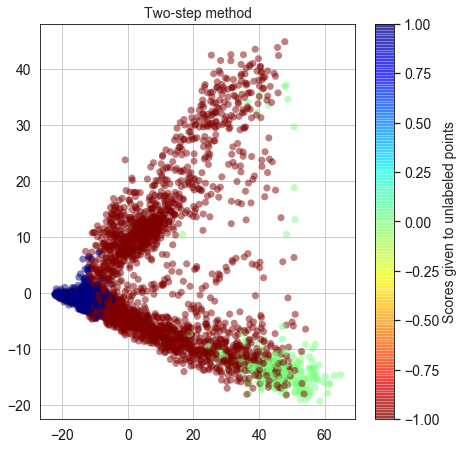

In [29]:
# visualize final TwoStep results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    X[:,0], X[:,1], 
    c = labels_twostep_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

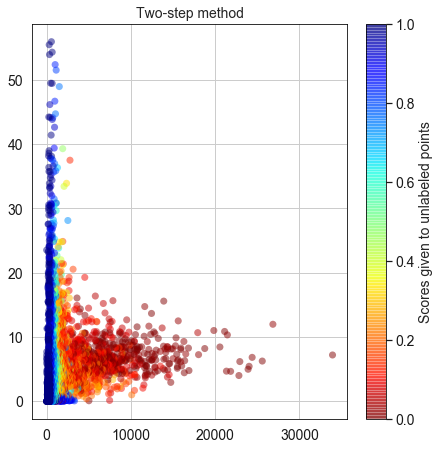

In [30]:
# visualize final TwoStep results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    s1.obs['total_counts'], s1.obs['pct_counts_mito'], 
    c = scores_twostep_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

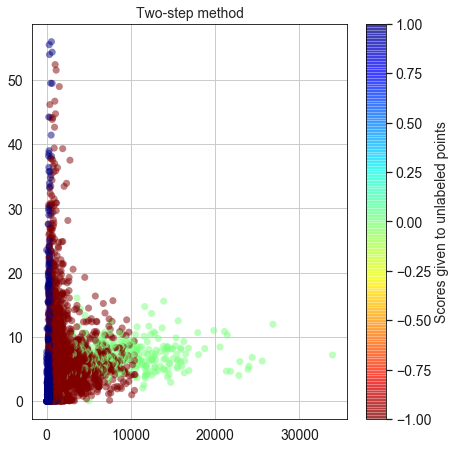

In [31]:
# visualize final TwoStep results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    s1.obs['total_counts'], s1.obs['pct_counts_mito'], 
    c = labels_twostep_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

In [ ]:
s1.obs['bagging_result'] = np.where(results_bagging_empty!=0, 1, 0)

In [ ]:
s1.obs['ken_filter'].value_counts()

In [ ]:
s1.obs['bagging_result'].value_counts()

In [ ]:
# look at our previously-defined labels
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='bagging_result', size=75)

In [ ]:
# look at low-quality and dead cell distribution with Ken's filtering
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='ken_filter', size=75)

In [ ]:
s1_notempty = s1[s1.obs['bagging_result']==0,:].copy() # move forward with non-empty droplets

In [ ]:
s1_notempty.X = s1_notempty.raw.X

### Normalize and perform linear dimensionality reduction with PCA

In [ ]:
%%time
sc.pp.normalize_total(s1_notempty, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1_notempty) # log1p transformation
sc.pp.scale(s1_notempty, max_value=10) # scaling by variance and centering to zero for visualization

In [ ]:
%%time
sc.tl.pca(s1_notempty, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1_notempty, color=['log1p_total_counts','pct_counts_mito','ken_filter'], ncols=3)

### Clustering

In [ ]:
%%time
sc.pp.neighbors(s1_notempty, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.louvain(s1_notempty, resolution=1.8, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

In [ ]:
sc.tl.paga(s1_notempty) #perform PAGA
sc.pl.paga(s1_notempty, frameon=False)

In [ ]:
sc.tl.umap(s1_notempty, init_pos=sc.tl._utils.get_init_pos_from_paga(s1_notempty))
sc.pl.umap(s1_notempty, color=['pct_counts_mito','log1p_total_counts','ken_filter','louvain'], frameon=False, ncols=2)

---
## Ken Filtering

In [ ]:
s1_gold = s1[s1.obs['ken_filter']==1,:].copy() # move forward with non-empty droplets

In [ ]:
s1_gold.X = s1_gold.raw.X

### Normalize and perform linear dimensionality reduction with PCA

In [ ]:
%%time
sc.pp.normalize_total(s1_gold, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1_gold) # log1p transformation
sc.pp.scale(s1_gold, max_value=10) # scaling by variance and centering to zero for visualization

In [ ]:
%%time
sc.tl.pca(s1_gold, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1_gold, color=['log1p_total_counts','pct_counts_mito','bagging_result'], ncols=3)

### Clustering

In [ ]:
%%time
sc.pp.neighbors(s1_gold, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.louvain(s1_gold, resolution=1.8, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

In [ ]:
sc.tl.paga(s1_gold) #perform PAGA
sc.pl.paga(s1_gold, frameon=False)

In [ ]:
sc.tl.umap(s1_gold, init_pos=sc.tl._utils.get_init_pos_from_paga(s1_gold))
sc.pl.umap(s1_gold, color=['pct_counts_mito','log1p_total_counts','bagging_result','louvain'], frameon=False, ncols=2)